A manual on exploiting the Mobpro batabase, with two tasks:
1. Histogram of nb of commuters sent from the attracted cities (unité urbaine)
2. ESOPE map

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from shapely.geometry import Point, Polygon
import shapely.geometry
import shapely.wkt
from shapely.geometry import LineString
import seaborn as sns

from matplotlib.colors import ListedColormap  
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from pysal.lib import weights
import networkx as nx
#import momepy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import geopy.distance
from math import sin, cos, sqrt, atan2, radians
from numpy import arcsin as asin
from typing import Tuple

In [6]:
data = pd.read_csv("Data/nantes_2018_simplifie_VMG_V2.csv", sep=";", dtype={'DCLT': 'str', 'COMMUNE': 'str','ARM':'str','REGION':'str','REGLT':'str'} ) 

communes = pd.read_csv("Data/communes.csv", sep=";", dtype={'insee': 'str'} )

"""paris_mar_lyon = pd.read_csv('C:/Users/kangl/Desktop/données/emploi/broto/Mirabel_2011/commune_2018/paris_marseille_lyon.csv', dtype={'insee': 'str'} ) 
commune_paris = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/communes/communes-dile-de-france-au-01-janvier/communes-dile-de-france-au-01-janvier.shp')
commune_france = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/France-entier/FR-metropolitaine/commune-2022/FR-commune.shp')"""

"paris_mar_lyon = pd.read_csv('C:/Users/kangl/Desktop/données/emploi/broto/Mirabel_2011/commune_2018/paris_marseille_lyon.csv', dtype={'insee': 'str'} ) \ncommune_paris = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/communes/communes-dile-de-france-au-01-janvier/communes-dile-de-france-au-01-janvier.shp')\ncommune_france = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/France-entier/FR-metropolitaine/commune-2022/FR-commune.shp')"

In [7]:
#drop useless columns
#commune_france = commune_france.drop(columns=['reg', 'cateaav20'])
#set the type as string
#commune_paris.insee = commune_paris.insee.astype(str)
data = data[['nomcom_O','nomcom_D','flux','distance','voy*km','VP*km','TC*km','emp_O','emp_D','actifs_O','actifs_D']]
communes_mans = communes[['nomcom','emp','actifs','PTOT','libuu2020']]
#region of destination IDF
#data_cut_D_IDF = data_cut[(data_cut['REGLT']=='11')].reset_index(drop=True)

In [8]:

data
communes_mans

,nomcom,emp,actifs,PTOT,libuu2020
0,Abbaretz,"300,9459949","990,9735568",2107.0,Commune hors unité urbaine du département 44
1,Aigrefeuille-sur-Maine,"1510,458098","1917,785163",4152.0,Aigrefeuille-sur-Maine
2,Ancenis-Saint-Géréon,"12683,55334","4314,703233",11435.0,Ancenis-Saint-Géréon
3,Chaumes-en-Retz,"1854,516006","3219,079333",7001.0,Chaumes-en-Retz
4,Assérac,"207,2714793","770,832",1889.0,Commune hors unité urbaine du département 44
...,...,...,...,...,...
1235,Vouvant,"175,3435689","352,2450616",929.0,Commune hors unité urbaine du département 85
1236,Xanton-Chassenon,"64,9473623","314,1393443",741.0,Commune hors unité urbaine du département 85
1237,NaN,"233,5856893","176,6954138",673.0,NaN
1238,NaN,NaN,NaN,NaN,NaN


In [9]:
filtered_communes = communes_mans[communes_mans["libuu2020"].isin(['Le Mans'])]
#explication de la ligne ci-dessus : on filtre les communes de la région Le Mans

In [10]:
filtered_communes

,nomcom,emp,actifs,PTOT,libuu2020
626,Aigné,"276,2695734","816,5146303",1735.0,Le Mans
628,Allonnes,"6214,524121","3423,408058",11276.0,Le Mans
633,Arnage,"3472,032098","1993,017385",5626.0,Le Mans
679,Changé,"1831,279491","2622,018024",6749.0,Le Mans
685,La Chapelle-Saint-Aubin,"2226,876371","916,5008764",2368.0,Le Mans
711,Coulaines,"2234,999004","2382,525634",7895.0,Le Mans
757,Guécélard,"327,1127313","1298,746774",3146.0,Le Mans
766,Laigné-en-Belin,"460,5072203","1018,738202",2353.0,Le Mans
790,Le Mans,"82759,53893","52338,88882",146703.0,Le Mans
807,La Milesse,"533,4524574","1162,398964",2673.0,Le Mans


In [11]:
list_communes_mans = filtered_communes['nomcom'].tolist()

In [12]:
list_communes_mans
#explication de la ligne ci-dessus : on crée une liste des communes de la région Le Mans

['Aigné',
 'Allonnes',
 'Arnage',
 'Changé',
 'La Chapelle-Saint-Aubin',
 'Coulaines',
 'Guécélard',
 'Laigné-en-Belin',
 'Le Mans',
 'La Milesse',
 'Moncé-en-Belin',
 'Mulsanne',
 'Ruaudin',
 'Saint-Gervais-en-Belin',
 'Saint-Pavace',
 'Saint-Saturnin',
 'Sargé-lès-le-Mans',
 "Savigné-l'Évêque",
 'Teloché',
 "Yvré-l'Évêque"]

In [13]:
#get the active population and employment in each commune
filtered_communes['actifs'] = filtered_communes['actifs'].str.replace(",", ".", regex=False)
filtered_communes['emp'] = filtered_communes['emp'].str.replace(",", ".", regex=False)


/var/folders/vs/j78w2y_93f32p8h5wv38xrcm0000gn/T/ipykernel_51067/8226650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_communes['actifs'] = filtered_communes['actifs'].str.replace(",", ".", regex=False)
/var/folders/vs/j78w2y_93f32p8h5wv38xrcm0000gn/T/ipykernel_51067/8226650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_communes['emp'] = filtered_communes['emp'].str.replace(",", ".", regex=False)


In [14]:
filtered_communes

,nomcom,emp,actifs,PTOT,libuu2020
626,Aigné,276.2695734,816.5146303,1735.0,Le Mans
628,Allonnes,6214.524121,3423.408058,11276.0,Le Mans
633,Arnage,3472.032098,1993.017385,5626.0,Le Mans
679,Changé,1831.279491,2622.018024,6749.0,Le Mans
685,La Chapelle-Saint-Aubin,2226.876371,916.5008764,2368.0,Le Mans
711,Coulaines,2234.999004,2382.525634,7895.0,Le Mans
757,Guécélard,327.1127313,1298.746774,3146.0,Le Mans
766,Laigné-en-Belin,460.5072203,1018.738202,2353.0,Le Mans
790,Le Mans,82759.53893,52338.88882,146703.0,Le Mans
807,La Milesse,533.4524574,1162.398964,2673.0,Le Mans


In [15]:
count_actifs = filtered_communes['actifs'].astype(float).sum()
count_emp = filtered_communes['emp'].astype(float).sum()    

In [16]:
count_actifs

82002.8412105

In [17]:
filtered_data_D = data[data["nomcom_D"].isin(list_communes_mans)]
filtered_data_O = data[data["nomcom_O"].isin(list_communes_mans)]

In [18]:
filtered_data_O['flux'] = filtered_data_O['flux'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['distance'] = filtered_data_O['distance'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['voy*km'] = filtered_data_O['voy*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['VP*km'] = filtered_data_O['VP*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['TC*km'] = filtered_data_O['TC*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['emp_O'] = filtered_data_O['emp_O'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['emp_D'] = filtered_data_O['emp_D'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['actifs_O'] = filtered_data_O['actifs_O'].str.replace(",", ".", regex=False).astype(float)
filtered_data_O['actifs_D'] = filtered_data_O['actifs_D'].str.replace(",", ".", regex=False).astype(float)

/var/folders/vs/j78w2y_93f32p8h5wv38xrcm0000gn/T/ipykernel_51067/2107466646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_O['flux'] = filtered_data_O['flux'].str.replace(",", ".", regex=False).astype(float)
/var/folders/vs/j78w2y_93f32p8h5wv38xrcm0000gn/T/ipykernel_51067/2107466646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_O['distance'] = filtered_data_O['distance'].str.replace(",", ".", regex=False).astype(float)
/var/folders/vs/j78w2y_93f32p8h5wv38xrcm0000gn/T/i

In [ ]:
filtered_data_D['flux'] = filtered_data_D['flux'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['distance'] = filtered_data_D['distance'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['voy*km'] = filtered_data_D['voy*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['VP*km'] = filtered_data_D['VP*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['TC*km'] = filtered_data_D['TC*km'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['emp_O'] = filtered_data_D['emp_O'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['emp_D'] = filtered_data_D['emp_D'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['actifs_O'] = filtered_data_D['actifs_O'].str.replace(",", ".", regex=False).astype(float)
filtered_data_D['actifs_D'] = filtered_data_D['actifs_D'].str.replace(",", ".", regex=False).astype(float)

In [20]:
filtered_data_O_wo_mans=filtered_data_O[filtered_data_O["nomcom_O"] != "Le Mans"]
filtered_data_D_wo_mans=filtered_data_D[filtered_data_D["nomcom_O"] != "Le Mans"]

In [21]:
filtered_data_D_wo_mans

,nomcom_O,nomcom_D,flux,distance,voy*km,VP*km,TC*km,emp_O,emp_D,actifs_O,actifs_D
192,Ancenis-Saint-Géréon,Le Mans,5.186365,124.064054,643.441437,0.000000,643.441437,12683.553340,82759.538930,4314.703233,52338.888820
283,Chaumes-en-Retz,Le Mans,4.952430,184.578394,914.111528,914.111528,0.000000,1854.516006,82759.538930,3219.079333,52338.888820
435,Basse-Goulaine,Changé,5.040103,111.328331,561.106224,561.106224,0.000000,3258.044288,4641.126192,3994.609116,2554.102876
704,Blain,Le Mans,4.937210,158.382528,781.967862,781.967862,0.000000,3552.595761,82759.538930,3955.838331,52338.888820
742,La Boissière-du-Doré,Le Mans,4.976281,134.519355,669.406087,669.406087,0.000000,253.977719,82759.538930,537.438330,52338.888820
...,...,...,...,...,...,...,...,...,...,...,...
41295,La Roche-sur-Yon,Allonnes,4.999993,185.225633,926.126952,926.126952,0.000000,42529.537270,6214.524121,20946.426330,3423.408058
41296,La Roche-sur-Yon,Le Mans,0.985295,190.423266,187.623186,187.623186,0.000000,42529.537270,82759.538930,20946.426330,52338.888820
41603,Les Sables-d'Olonne,Le Mans,4.059548,220.568020,895.406487,895.406487,0.000000,17336.678860,82759.538930,13725.570540,52338.888820
42283,Saint-Fulgent,Arnage,4.975092,155.624601,774.246647,0.000000,774.246647,2785.248318,3472.032098,1719.250703,1993.017385


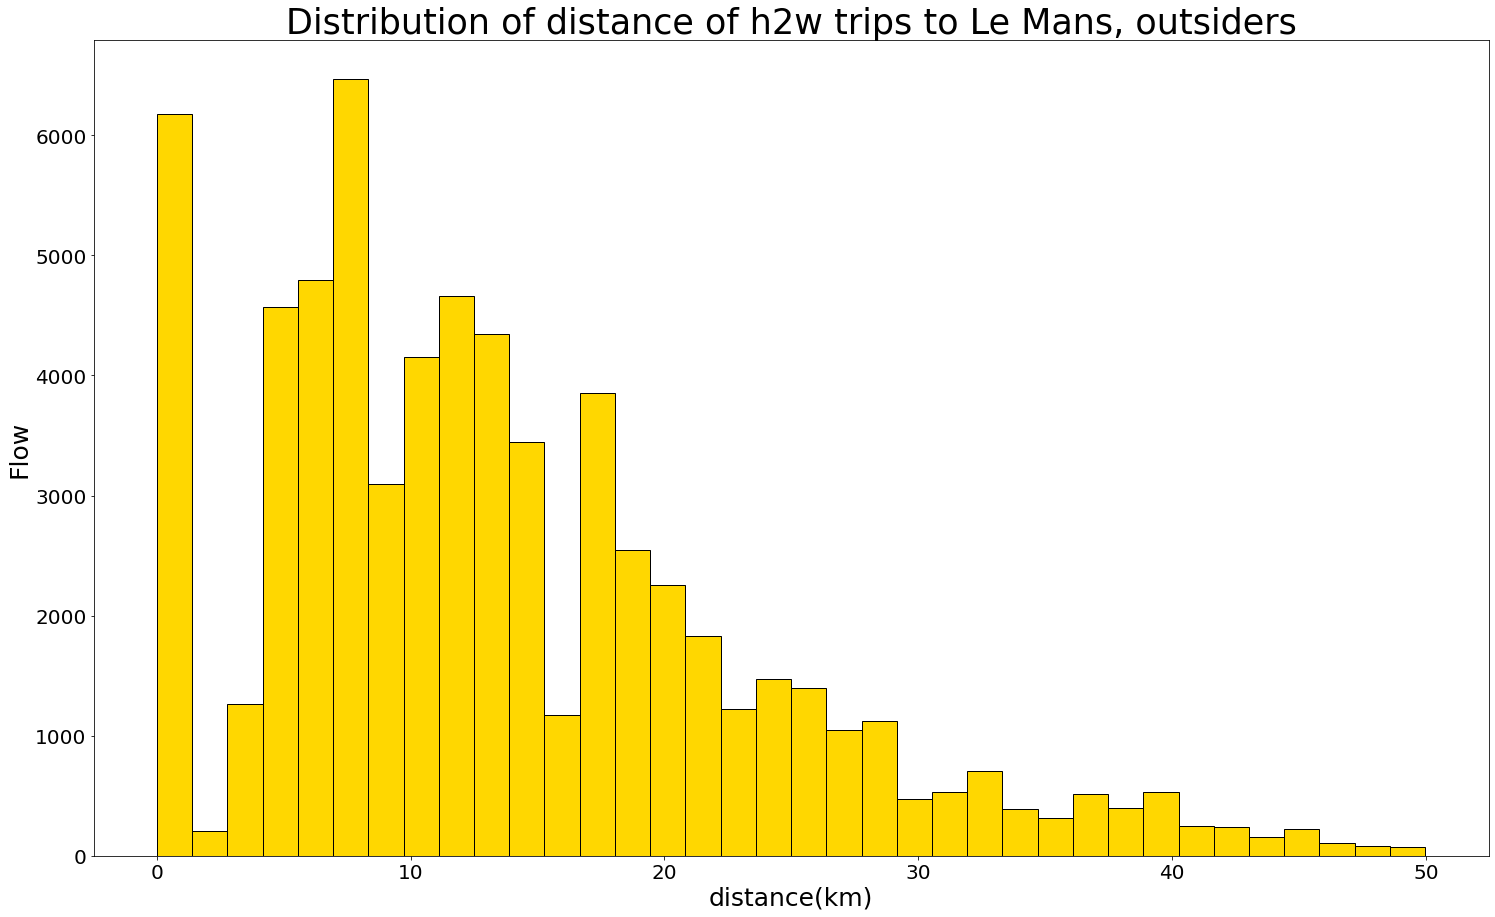

In [31]:
fig, ax = plt.subplots(figsize=(25,15))

#ax.set(xticks=range(10), xlim=[0, 500])
distance = filtered_data_D_wo_mans.distance
weight = filtered_data_D_wo_mans.flux

distance_pre50 = distance[distance<50]
distance_post50 = distance[distance>=50]
weight_pre50 = weight[distance<50]
weight_post50 = weight[distance>=50]

plt.hist(distance_pre50 , color = 'gold', edgecolor = 'black',weights =weight_pre50, bins=int(915/25),align='mid')
plt.title('Distribution of distance of h2w trips to Le Mans, outsiders',fontsize=35)
plt.xlabel('distance(km)',fontsize=25)
plt.ylabel('Flow',fontsize=25)
plt.xticks(np.arange(0, 60, 10),fontsize=20)
plt.yticks(fontsize=20)

plt.show()

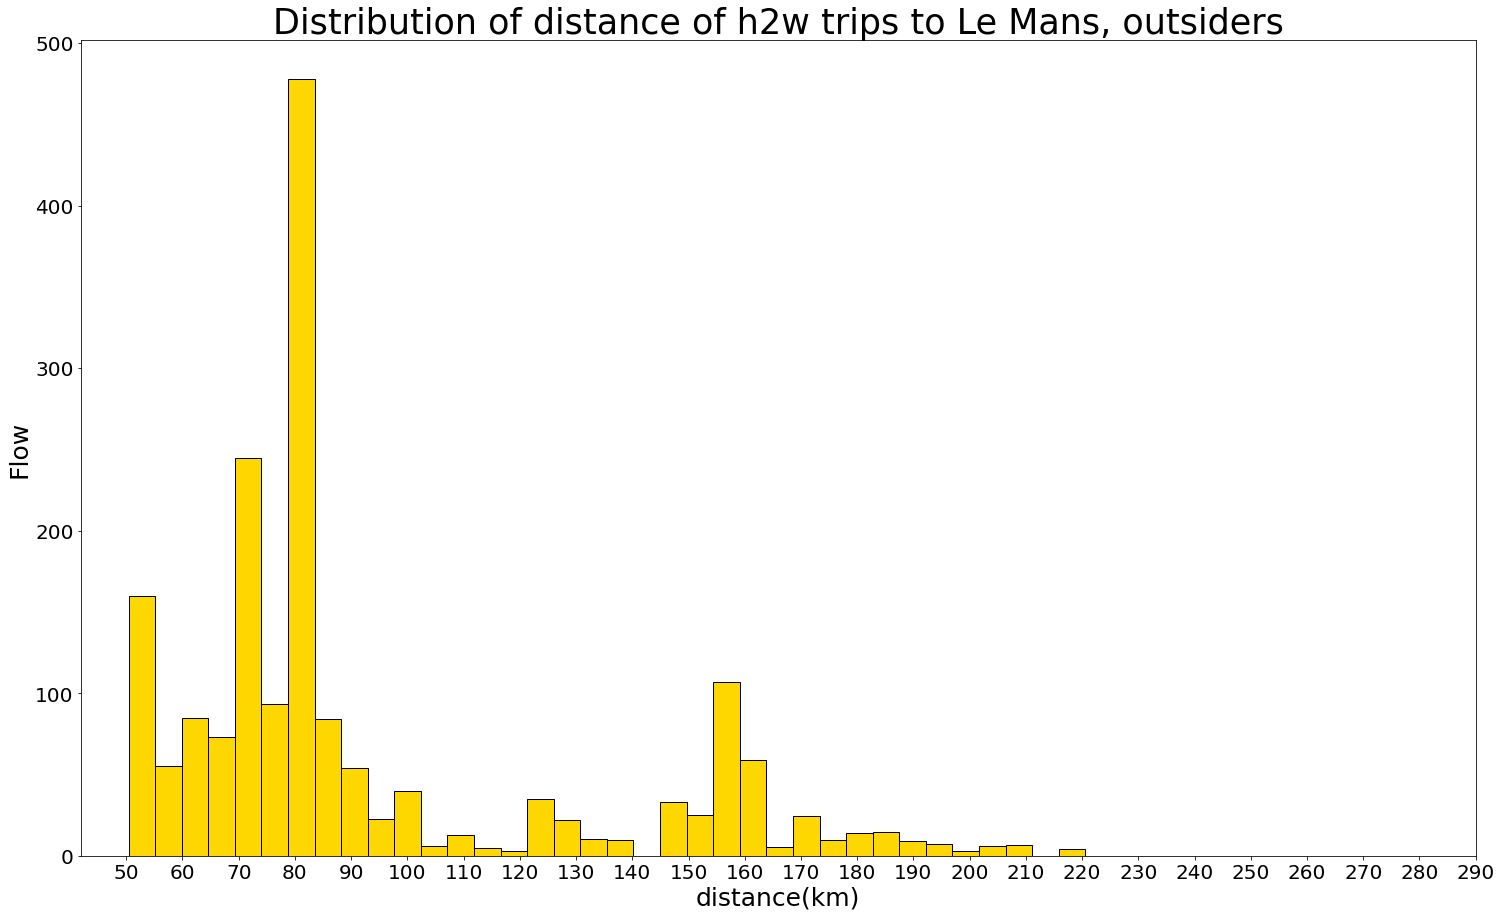

In [33]:
fig, ax = plt.subplots(figsize=(25,15))
plt.hist(distance_post50 , color = 'gold', edgecolor = 'black',weights =weight_post50, bins=int(915/25),align='mid')
plt.title('Distribution of distance of h2w trips to Le Mans, outsiders',fontsize=35)
plt.xlabel('distance(km)',fontsize=25)
plt.ylabel('Flow',fontsize=25)
plt.xticks(np.arange(50, 300, 10),fontsize=20)
plt.yticks(fontsize=20)
plt.show()

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

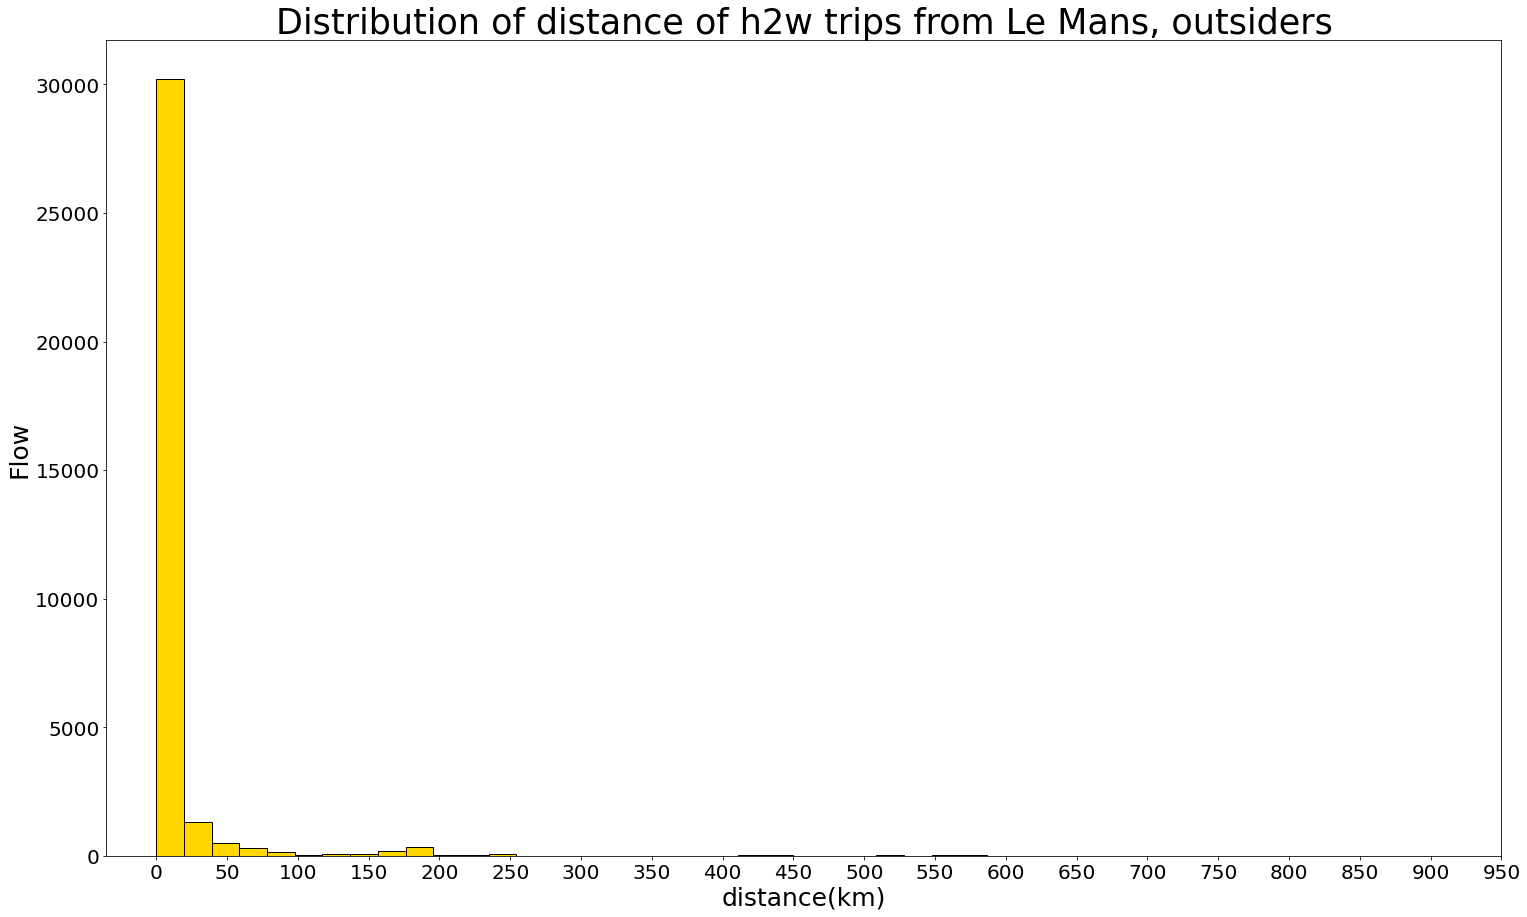

In [23]:
fig, ax = plt.subplots(figsize=(25,15))

#ax.set(xticks=range(10), xlim=[0, 1000])
distance = filtered_data_O_wo_mans.distance
weight = filtered_data_O_wo_mans.flux

plt.hist(distance , color = 'gold', edgecolor = 'black',weights =weight, bins=int(915/25),align='mid')
#sns.distplot(distance, bins=50, color='blue', label='dep',hist_kws={"edgecolor": 'black','weights':weight},kde_kws={'bw':0.2})

plt.title('Distribution of distance of h2w trips from Le Mans, outsiders',fontsize=35)
plt.xlabel('distance(km)',fontsize=25)
plt.ylabel('Flow',fontsize=25)

plt.xticks(np.arange(0, 1000, 50),fontsize=20)
plt.yticks(fontsize=20)

In [24]:
filtered_data_D.sort_values(by='flux', ascending=False).head(10)


,nomcom_O,nomcom_D,flux,distance,voy*km,VP*km,TC*km,emp_O,emp_D,actifs_O,actifs_D
30558,Le Mans,Le Mans,37474.073030,0.011006,412.448175,226.191681,84.479968,82759.538930,82759.538930,52338.888820,52338.888820
30478,Le Mans,Allonnes,1746.450101,5.295360,9248.081272,7409.310818,1231.346055,82759.538930,6214.524121,52338.888820,3423.408058
26238,Allonnes,Le Mans,1592.841775,5.333492,8495.409375,6311.279006,1889.050473,6214.524121,82759.538930,3423.408058,52338.888820
27516,Changé,Le Mans,1296.767484,7.306784,9475.200210,8924.132027,179.883351,1831.279491,82759.538930,2622.018024,52338.888820
28241,Coulaines,Le Mans,1195.734324,5.027633,6011.712990,3971.221795,1439.848869,2234.999004,82759.538930,2382.525634,52338.888820
26209,Allonnes,Allonnes,1077.693789,0.041965,45.225695,23.426912,6.366778,6214.524121,6214.524121,3423.408058,3423.408058
23584,Laval,Changé,974.618154,5.813718,5666.154658,5044.514368,237.442872,35224.162330,4641.126192,18964.996380,2554.102876
31495,Mulsanne,Le Mans,936.586251,8.444913,7909.389696,7317.242874,507.554419,1421.790535,82759.538930,2118.588150,52338.888820
26402,Arnage,Le Mans,930.893633,6.636291,6177.680589,5410.891955,498.873747,3472.032098,82759.538930,1993.017385,52338.888820
31939,Parigné-l'Évêque,Le Mans,865.000000,14.271468,12344.819930,11702.603860,214.072022,1464.683352,82759.538930,2120.000000,52338.888820


In [25]:
#get the mode share per OD
table = pd.pivot_table(data_cut_D_IDF_FM, values='IPONDI', index=['COMMUNE','ARM','DCLT','REGION','REGLT'],
                    columns=['TRANS'], aggfunc=np.sum).reset_index()
table = table.fillna(0)
table = table.rename({1: 'non_tran', 2: "Map", 3: "velo",4: "2_roue", 5: "VP", 6: "TC"},axis=1)

NameError: name 'data_cut_D_IDF_FM' is not defined

In [ ]:
table 

TRANS,COMMUNE,ARM,DCLT,REGION,REGLT,non_tran,Map,velo,2_roue,VP,TC
0,01004,ZZZZZ,75111,84,11,0.000000,0.0,0.0,0.0,3.493897,3.614551
1,01004,ZZZZZ,77307,84,11,0.000000,0.0,0.0,0.0,6.745912,0.000000
2,01004,ZZZZZ,78551,84,11,3.493897,0.0,0.0,0.0,0.000000,0.000000
3,01004,ZZZZZ,91687,84,11,0.000000,0.0,0.0,0.0,3.158472,0.000000
4,01004,ZZZZZ,92026,84,11,0.000000,0.0,0.0,0.0,0.000000,3.740902
...,...,...,...,...,...,...,...,...,...,...,...
179490,95690,ZZZZZ,95500,11,11,0.000000,0.0,0.0,0.0,4.942941,0.000000
179491,95690,ZZZZZ,95585,11,11,0.000000,0.0,0.0,0.0,5.022839,0.000000
179492,95690,ZZZZZ,95637,11,11,0.000000,0.0,0.0,0.0,4.864314,0.000000
179493,95690,ZZZZZ,95658,11,11,0.000000,0.0,0.0,0.0,9.885883,0.000000


In [ ]:
#get the lattitude and longitude of each commune in France and IDF
#change the projection to the Lampert 93
commune_france['O_long'] = commune_france.geometry.centroid.x
commune_france['O_lat'] = commune_france.geometry.centroid.y
commune_france = commune_france.to_crs(2154)

commune_paris['D_long'] = commune_paris.geometry.centroid.x
commune_paris['D_lat'] = commune_paris.geometry.centroid.y
commune_paris = commune_paris.to_crs(2154)

C:\Users\kangl\AppData\Local\Temp\ipykernel_12456\4217573309.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_france['O_long'] = commune_france.geometry.centroid.x
C:\Users\kangl\AppData\Local\Temp\ipykernel_12456\4217573309.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_france['O_lat'] = commune_france.geometry.centroid.y
C:\Users\kangl\AppData\Local\Temp\ipykernel_12456\4217573309.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_paris['D_long'] = commune_paris.geometry.centroid.x
C:\Users\kangl\AppData\Local\Temp\ipykernel_12456\42175

In [ ]:
#since the code of commune for Paris Lyon and Marseille are at the arrondissement level, we need to treat them separately
paris_mar_lyon.code_insee = paris_mar_lyon.code_insee.astype(str)

In [ ]:
#merge tables based on origin and destination
table_1 = table.merge(commune_france,left_on='COMMUNE', right_on='codgeo',how = 'left')
table_2 = table_1.merge(paris_mar_lyon,left_on='ARM', right_on='code_insee',how = 'left')
table_3 = table_2.merge(commune_paris,left_on='DCLT', right_on='insee',how = 'left')

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# we can set the distance as the distance between OD or distance between commune and the center of IDF

In [ ]:
#in the case when we choose to calculate the distance between the origin commune and the center of IDF(paris)

In [ ]:
table_paris = table_3[(table_3['COMMUNE']=='75056')&(table_3['ARM']=='75101')&(table_3['DCLT']=='75101')].iloc[0]
coordinate_Paris_lat = table_paris.O_lat
coordinate_Paris_long = table_paris.O_long

In [ ]:
table_3['distance'] = table_3.apply(lambda x:haversine(coordinate_Paris_long,coordinate_Paris_lat, x['O_long'], x['O_lat']), axis = 1)
table_3['flux']=table_3['non_tran']+table_3['Map']+table_3['velo']+table_3['2_roue']+table_3['VP']+table_3['TC']

table_4 = table_3.merge(marge_emploi_commune, how='left', left_on='COMMUNE', right_on='O_DCLT')
table_4 = table_4.merge(marge_actif_commune, how='left', left_on='COMMUNE', right_on='COMMUNE')

In [ ]:
table_4 

,COMMUNE,ARM,DCLT,REGION,REGLT,non_tran,Map,velo,2_roue,VP,...,st_areasha,st_lengths,geometry_y,D_long,D_lat,distance,flux,O_DCLT,emp,actifs
0,01004,ZZZZZ,75111,84,11,0.000000,0.0,0.0,0.0,3.493897,...,NaN,NaN,None,NaN,NaN,394.509980,7.108448,01004,7778.134459,5967.604002
1,01004,ZZZZZ,77307,84,11,0.000000,0.0,0.0,0.0,6.745912,...,NaN,NaN,None,NaN,NaN,394.509980,6.745912,01004,7778.134459,5967.604002
2,01004,ZZZZZ,78551,84,11,3.493897,0.0,0.0,0.0,0.000000,...,NaN,NaN,None,NaN,NaN,394.509980,3.493897,01004,7778.134459,5967.604002
3,01004,ZZZZZ,91687,84,11,0.000000,0.0,0.0,0.0,3.158472,...,NaN,NaN,None,NaN,NaN,394.509980,3.158472,01004,7778.134459,5967.604002
4,01004,ZZZZZ,92026,84,11,0.000000,0.0,0.0,0.0,0.000000,...,NaN,NaN,None,NaN,NaN,394.509980,3.740902,01004,7778.134459,5967.604002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179490,95690,ZZZZZ,95500,11,11,0.000000,0.0,0.0,0.0,4.942941,...,NaN,NaN,None,NaN,NaN,46.180334,4.942941,95690,24.970572,188.510216
179491,95690,ZZZZZ,95585,11,11,0.000000,0.0,0.0,0.0,5.022839,...,NaN,NaN,None,NaN,NaN,46.180334,5.022839,95690,24.970572,188.510216
179492,95690,ZZZZZ,95637,11,11,0.000000,0.0,0.0,0.0,4.864314,...,NaN,NaN,None,NaN,NaN,46.180334,4.864314,95690,24.970572,188.510216
179493,95690,ZZZZZ,95658,11,11,0.000000,0.0,0.0,0.0,9.885883,...,NaN,NaN,None,NaN,NaN,46.180334,9.885883,95690,24.970572,188.510216


# make the table AO_aav(active outsider coming from towns outside the region)

In [ ]:
AO = data_cut.groupby(['COMMUNE']).IPONDI.sum().reset_index()
AO_aav = AO.merge(commune_france,left_on='COMMUNE', right_on='codgeo',how = 'left')
AO_aav =  AO_aav[AO_aav['codgeo'].notna()].reset_index(drop=True)
AO_aav = AO_aav.groupby(['libaav2020','aav2020']).IPONDI.sum().reset_index()
AO_aav

,libaav2020,aav2020,IPONDI
0,Abbeville,164,20030.583408
1,Agde,166,16410.769920
2,Agen,093,49694.286838
3,Aime-la-Plagne,645,2188.989431
4,Aire-sur-l'Adour,421,4703.435381
...,...,...,...
678,Épinal,095,48103.354498
679,Étain,629,1855.117509
680,Étaples - Le Touquet-Paris-Plage,247,11132.665685
681,Évreux,083,55107.987611


In [ ]:
flux_table = pd.pivot_table(table_4, values=['flux','distance'], index=['aav2020','libaav2020'], aggfunc={'flux': np.sum,
                             'distance': np.mean,}).reset_index()
flux_table

,aav2020,libaav2020,distance,flux
0,000,Commune hors attraction des villes,218.742230,2.136968e+04
1,001,Paris,31.197913,5.539943e+06
2,002,Lyon,393.576692,7.776711e+03
3,003,Marseille - Aix-en-Provence,652.972245,5.328795e+03
4,004,Lille (partie française),204.111783,7.297418e+03
...,...,...,...,...
645,GEN,Genève - Annemasse (partie française),412.943075,5.272129e+02
646,LAU,Lausanne (partie française),421.344105,2.000000e+01
647,LUX,Luxembourg (partie française),280.657023,4.694266e+02
648,MON,Monaco - Menton (partie française),688.413052,9.348520e+01


In [ ]:
flux_table = flux_table.drop({'libaav2020'},axis=1)
flux_table_fin = flux_table.merge(AO_aav,left_on='aav2020', right_on='aav2020',how = 'left')
flux_table_fin['pctg']=flux_table_fin['flux']/flux_table_fin['IPONDI']
flux_table_fin = flux_table_fin.sort_values(by=['aav2020'], ascending=False).reset_index(drop=True)

In [ ]:
flux_table_fin

,aav2020,distance,flux,libaav2020,IPONDI,pctg
0,SAR,340.338052,5.606046e+01,Sarrebruck (partie française),1.346403e+04,0.004164
1,MON,688.413052,9.348520e+01,Monaco - Menton (partie française),3.195817e+04,0.002925
2,LUX,280.657023,4.694266e+02,Luxembourg (partie française),1.276456e+05,0.003678
3,LAU,421.344105,2.000000e+01,Lausanne (partie française),6.241375e+03,0.003204
4,GEN,412.943075,5.272129e+02,Genève - Annemasse (partie française),2.040040e+05,0.002584
...,...,...,...,...,...,...
645,004,204.111783,7.297418e+03,Lille (partie française),6.002091e+05,0.012158
646,003,652.972245,5.328795e+03,Marseille - Aix-en-Provence,7.147399e+05,0.007456
647,002,393.576692,7.776711e+03,Lyon,9.677089e+05,0.008036
648,001,31.197913,5.539943e+06,Paris,5.833864e+06,0.949618


In [ ]:
#save this file for drawing the ESOPE map later
flux_table_fin.to_csv('C:/Users/kangl/Desktop/CSMM/flux_table_fin.csv')

# plot the distribution of distance

In [ ]:
#drop the row of Paris
flux_table_fin = flux_table_fin.drop(flux_table_fin[flux_table_fin.IPONDI > 1000000].index).reset_index(drop=True)

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

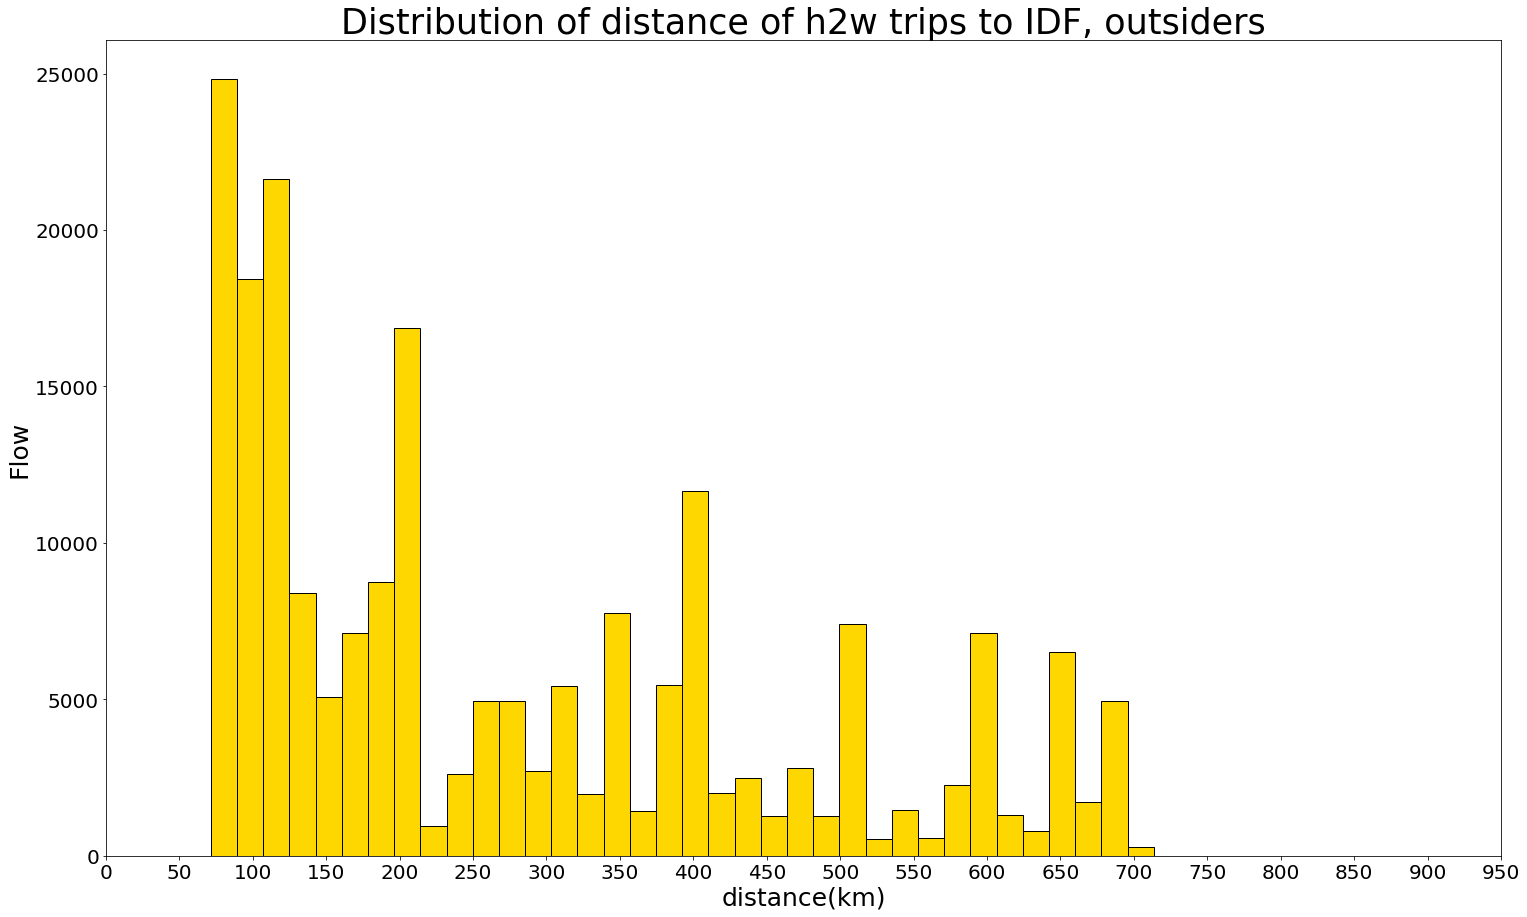

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(25,15))

#ax.set(xticks=range(10), xlim=[0, 1000])
distance = flux_table_fin.distance
weight = flux_table_fin.flux

plt.hist(distance , color = 'gold', edgecolor = 'black',weights =weight, bins=int(915/25),align='mid')
#sns.distplot(distance, bins=50, color='blue', label='dep',hist_kws={"edgecolor": 'black','weights':weight},kde_kws={'bw':0.2})

plt.title('Distribution of distance of h2w trips to IDF, outsiders',fontsize=35)
plt.xlabel('distance(km)',fontsize=25)
plt.ylabel('Flow',fontsize=25)

plt.xticks(np.arange(0, 1000, 50),fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('C:/Users/kangl/Desktop/données/emploi/broto/Mirabel_2011/commune_2018/foo.png')